# Single Segmentation Model

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader, random_split

from dataset import PlantDataset, get_binary_target

from utils import (
    display_masks,
    display_batch_masks,
    upscale_logits, # quizas deberian ir al modulo del modelo?
    flatten_logits,
    set_seed,
    )

from evaluation import (
    compute_intersection_over_union,
    get_pred_label,
    compute_iou,
)

from transformers import (
    SegformerForSemanticSegmentation,
    SegformerImageProcessor,
)

from PIL import Image 
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Load Functions

For any explanation and usage of the functions below, please see
`playground.ipynb` in the root directory.


In [2]:
label2id = {'normal': 0, 'normal_cut': 1, 'noise': 2}

dataset = PlantDataset('data', 'cwt', 'data_inventary.csv', label2id=label2id)
feature_extractor = SegformerImageProcessor.from_pretrained("nvidia/mit-b0")

def collate_fn(batch, target_fn=get_binary_target):
    """
        Collate function to stack the masks as channels in the same tensor.
        get_target: function to get the target tensor from the masks and labels
            could be multi-labeling or binary.
    """ 
    # Acá se pueden agregar todas las transformacaiones adicionales de preproceso
    # que se requieran para las máscaras. Lo única esencial es pasar una PIL.Image
    # a tensor
    tfms = ToTensor()
    images = torch.cat([feature_extractor(example['image'], return_tensors='pt')['pixel_values'] for example in batch])
    masks = [example['masks'] for example in batch]
    labels = [example['labels'] for example in batch]
    targets = torch.cat([target_fn(x[0], x[1], tfms, size=(512,512)) for x in zip(masks, labels)])

    # transformar a 1 cuando haya un entero distinto a 0 (semantic segmentation)
    targets = torch.where(targets > 0.0, 1.0, 0.0)
    return images, targets

/home/alkzar/.pyenv/versions/3.8.5/envs/eda/lib/python3.8/site-packages/transformers/models/segformer/image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


## Train a single batch

In [3]:
set_seed(42313988)  # for reproducibility
#set_seed(42310912)  # for reproducibility
BS = 4      # Batch size
lr = 1e-3 

stoi = {'normal': 1, 'non-detection': 0}
itos = {1: 'normal', 0: 'non-detection'}

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b0",
    id2label=stoi,
    label2id=itos,
)

# model to device
model=model.to(device)

loss_fn = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

dataloader = DataLoader(dataset, batch_size=BS, shuffle=True, num_workers=0,
                        collate_fn = 
                        lambda x: collate_fn(x, target_fn=get_binary_target))

xb, yb = next(iter(dataloader))

xb=xb.to(device)
yb=yb.to(device)
xb.shape, yb.shape

Random seed set as 42313988


Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.classifier.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.3.proj.bias', 'decode_head.batc

(torch.Size([4, 3, 512, 512]), torch.Size([4, 1, 512, 512]))

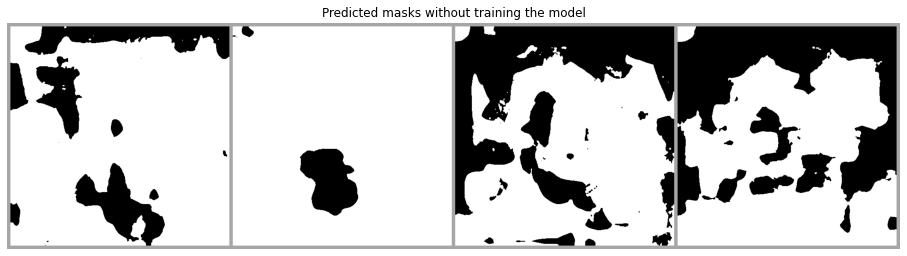

In [4]:
model.eval()
preds = torch.argmax(torch.softmax(upscale_logits(model(xb)["logits"]), dim=1), dim=1).unsqueeze(1).detach().cpu()
display_batch_masks(preds, caption=f'Predicted masks without training the model')
#plt.savefig("./assets/single-segmentation-overfitting-a-batch-without-training.png", dpi=300, bbox_inches='tight')

Random seed set as 42313988


  0%|          | 1/350 [00:00<05:18,  1.10it/s]

 -- Loss at epoch 0: 0.6968 | mIoU: 0.0000


  3%|▎         | 11/350 [00:09<04:37,  1.22it/s]

 -- Loss at epoch 10: 0.0936 | mIoU: 0.7955


  6%|▌         | 21/350 [00:17<04:25,  1.24it/s]

 -- Loss at epoch 20: 0.0416 | mIoU: 0.4643


  9%|▉         | 31/350 [00:25<04:19,  1.23it/s]

 -- Loss at epoch 30: 0.0405 | mIoU: 0.3145


 12%|█▏        | 41/350 [00:33<04:16,  1.20it/s]

 -- Loss at epoch 40: 0.0294 | mIoU: 0.2378


 15%|█▍        | 51/350 [00:41<04:07,  1.21it/s]

 -- Loss at epoch 50: 0.0252 | mIoU: 0.1912


 17%|█▋        | 61/350 [00:50<03:53,  1.24it/s]

 -- Loss at epoch 60: 0.0229 | mIoU: 0.1598


 20%|██        | 71/350 [00:58<03:50,  1.21it/s]

 -- Loss at epoch 70: 0.0208 | mIoU: 0.1373


 23%|██▎       | 81/350 [01:06<03:39,  1.22it/s]

 -- Loss at epoch 80: 0.0198 | mIoU: 0.1204


 26%|██▌       | 91/350 [01:14<03:30,  1.23it/s]

 -- Loss at epoch 90: 0.0190 | mIoU: 0.1071


 29%|██▉       | 101/350 [01:22<03:25,  1.21it/s]

 -- Loss at epoch 100: 0.0173 | mIoU: 0.0965


 32%|███▏      | 111/350 [01:31<03:13,  1.23it/s]

 -- Loss at epoch 110: 0.0157 | mIoU: 0.0878


 35%|███▍      | 121/350 [01:39<03:05,  1.23it/s]

 -- Loss at epoch 120: 0.0140 | mIoU: 0.0806


 37%|███▋      | 131/350 [01:47<03:03,  1.19it/s]

 -- Loss at epoch 130: 0.0136 | mIoU: 0.0744


 40%|████      | 141/350 [01:55<02:54,  1.20it/s]

 -- Loss at epoch 140: 0.0120 | mIoU: 0.0691


 43%|████▎     | 151/350 [02:04<02:51,  1.16it/s]

 -- Loss at epoch 150: 0.0101 | mIoU: 0.0646


 46%|████▌     | 161/350 [02:12<02:35,  1.22it/s]

 -- Loss at epoch 160: 0.0102 | mIoU: 0.0606


 49%|████▉     | 171/350 [02:20<02:27,  1.22it/s]

 -- Loss at epoch 170: 0.0089 | mIoU: 0.0570


 52%|█████▏    | 181/350 [02:29<02:21,  1.19it/s]

 -- Loss at epoch 180: 0.0087 | mIoU: 0.0539


 55%|█████▍    | 191/350 [02:37<02:13,  1.19it/s]

 -- Loss at epoch 190: 0.0082 | mIoU: 0.0510


 57%|█████▋    | 201/350 [02:45<02:03,  1.20it/s]

 -- Loss at epoch 200: 0.0071 | mIoU: 0.0485


 60%|██████    | 211/350 [02:54<02:03,  1.12it/s]

 -- Loss at epoch 210: 0.0070 | mIoU: 0.0462


 63%|██████▎   | 221/350 [03:02<01:48,  1.18it/s]

 -- Loss at epoch 220: 0.0067 | mIoU: 0.0441


 66%|██████▌   | 231/350 [03:11<01:42,  1.16it/s]

 -- Loss at epoch 230: 0.0063 | mIoU: 0.0422


 69%|██████▉   | 241/350 [03:20<01:32,  1.18it/s]

 -- Loss at epoch 240: 0.0059 | mIoU: 0.0405


 72%|███████▏  | 251/350 [03:28<01:24,  1.17it/s]

 -- Loss at epoch 250: 0.0056 | mIoU: 0.0388


 75%|███████▍  | 261/350 [03:37<01:15,  1.18it/s]

 -- Loss at epoch 260: 0.0094 | mIoU: 0.0374


 77%|███████▋  | 271/350 [03:45<01:07,  1.18it/s]

 -- Loss at epoch 270: 0.0060 | mIoU: 0.0360


 80%|████████  | 281/350 [03:54<01:01,  1.13it/s]

 -- Loss at epoch 280: 0.0057 | mIoU: 0.0347


 83%|████████▎ | 291/350 [04:02<00:50,  1.17it/s]

 -- Loss at epoch 290: 0.0053 | mIoU: 0.0335


 86%|████████▌ | 301/350 [04:11<00:41,  1.19it/s]

 -- Loss at epoch 300: 0.0050 | mIoU: 0.0324


 89%|████████▉ | 311/350 [04:20<00:34,  1.15it/s]

 -- Loss at epoch 310: 0.0048 | mIoU: 0.0314


 92%|█████████▏| 321/350 [04:29<00:25,  1.12it/s]

 -- Loss at epoch 320: 0.0047 | mIoU: 0.0304


 95%|█████████▍| 331/350 [04:37<00:16,  1.19it/s]

 -- Loss at epoch 330: 0.0046 | mIoU: 0.0295


 97%|█████████▋| 341/350 [04:46<00:07,  1.18it/s]

 -- Loss at epoch 340: 0.0060 | mIoU: 0.0286


100%|██████████| 350/350 [04:53<00:00,  1.19it/s]

--- 293.7642045021057 seconds ---


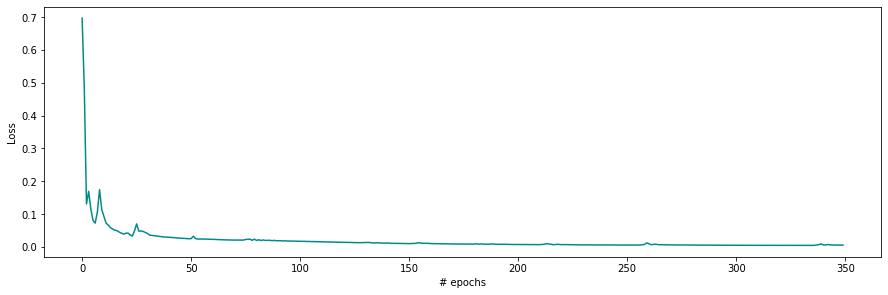

In [5]:
n_epochs = 350
eval_steps=10

# compute running time
start_time = time.time()

set_seed()  # for reproducibility

# the target will be constant (just one batch)
lossi = np.zeros(n_epochs)
cur_iou = []
for idx in tqdm(range(n_epochs)):

  # Perform a forward pass
  logits = model(xb)["logits"]

  # Clean the gradients  
  optimizer.zero_grad()

  # Compute the loss with class probabilities 
  loss = loss_fn(upscale_logits(logits),
                 yb.squeeze(1).to(torch.long)
  )

  # store the current loss value
  cur_loss = loss.item()
  cur_iou.append(compute_intersection_over_union(logits.float(), yb.float()))
  lossi[idx] = cur_loss

  # Backward prop
  loss.backward()

  # Update the parameters
  optimizer.step()

  if idx%eval_steps== 0:
    print(f" -- Loss at epoch {idx}: {cur_loss:.4f} | mIoU: {np.mean(cur_iou):.4f}")

# compute running time
end_time = time.time()
print(f"--- {end_time - start_time} seconds ---")


plt.figure(figsize=(15, 4.6));
plt.plot(lossi, color="darkcyan");
plt.xlabel("# epochs");
plt.ylabel("Loss");

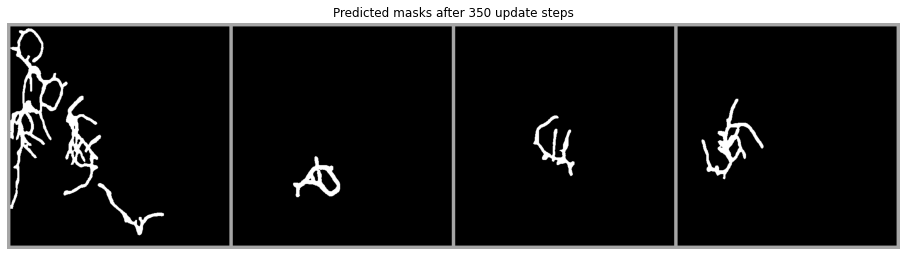

In [6]:
model.eval()
logits = upscale_logits(model(xb)["logits"])
preds = torch.argmax(torch.softmax(logits, dim=1), dim=1).unsqueeze(1).cpu()
display_batch_masks(preds, caption=f'Predicted masks after {n_epochs} update steps')
#plt.savefig("./assets/single-segmentation-overfitting-a-batch.png", dpi=300, bbox_inches='tight')

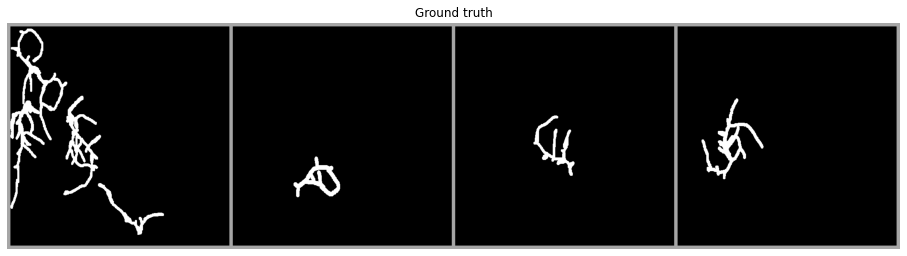

In [7]:
display_batch_masks(yb.max(dim=1)[0].unsqueeze(1).cpu(), caption='Ground truth')
#plt.savefig("./assets/single-segmentation-overfitting-a-batch-truth.png", dpi=300, bbox_inches='tight')

## Train on the entire dataset

In [8]:
set_seed(42313988)
# Hyperparameters --------------------------------------------------------------
lr = 1e-3           # learning rate
n_steps = 301       # number of steps to update the gradients
eval_steps=25       # evaluate every 10 epochs
BS = 2              # batch-size

# DataLoaders ------------------------------------------------------------------
val_pct = 0.15  # % of validation data
val_size= int(len(dataset) * val_pct)
train_size = len(dataset) - val_size
val_size, train_size

# Split the dataset into training and validation sets
train_set, val_set = random_split(dataset, [train_size, val_size])

# Create data loaders for the training and validation sets
train_loader = DataLoader(train_set, batch_size=BS, 
                          shuffle=True, num_workers=0,
                          collate_fn = lambda x: collate_fn(x, target_fn=get_binary_target))

val_loader = DataLoader(val_set, batch_size=BS, 
                        shuffle=False, num_workers=0,
                        collate_fn = lambda x: collate_fn(x, target_fn=get_binary_target))

Random seed set as 42313988


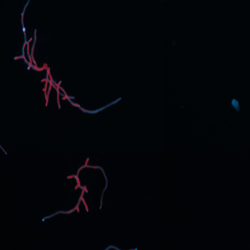

In [9]:
val_set[0]['image'].resize((250, 250))

In [10]:
# Model ----------------------------------------------------------------------- 
set_seed(42313988)  # for reproducibility

stoi = {'normal': 1, 'non-detection': 0}
itos = {1: 'normal', 0: 'non-detection'}

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b0",
    id2label=stoi,
    label2id=itos,
)

# model to device
model=model.to(device)

# Optimizer and loss function --------------------------------------------------
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

Random seed set as 42313988


Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.classifier.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.3.proj.bias', 'decode_head.batc

Random seed set as 42313988


  0%|          | 1/301 [00:03<16:31,  3.31s/it]

Saving a checkpoint...
Checkpoint saved!
 -- Loss at epoch 0: 0.6795 | mIoU: 0.2419


  9%|▊         | 26/301 [00:21<06:30,  1.42s/it]

 -- Loss at epoch 25: 0.2231 | mIoU: 0.0000


 17%|█▋        | 51/301 [00:38<05:21,  1.29s/it]

 -- Loss at epoch 50: 0.0680 | mIoU: 0.0000


 25%|██▌       | 76/301 [00:56<04:59,  1.33s/it]

Saving a checkpoint...
Checkpoint saved!
 -- Loss at epoch 75: 0.0591 | mIoU: 0.4718


 34%|███▎      | 101/301 [01:14<04:34,  1.37s/it]

Saving a checkpoint...
Checkpoint saved!
 -- Loss at epoch 100: 0.0654 | mIoU: 0.5023


 42%|████▏     | 126/301 [01:32<03:53,  1.33s/it]

 -- Loss at epoch 125: 0.0311 | mIoU: 0.2921


 50%|█████     | 151/301 [01:50<03:19,  1.33s/it]

 -- Loss at epoch 150: 0.0466 | mIoU: 0.0837


 58%|█████▊    | 176/301 [02:08<02:47,  1.34s/it]

 -- Loss at epoch 175: 0.0498 | mIoU: 0.1673


 67%|██████▋   | 201/301 [02:26<02:13,  1.34s/it]

 -- Loss at epoch 200: 0.0353 | mIoU: 0.0231


100%|██████████| 5/5 [00:02<00:00,  2.07it/s]t/s]


Saving a checkpoint...


 75%|███████▌  | 226/301 [02:45<01:52,  1.49s/it]

Checkpoint saved!
 -- Loss at epoch 225: 0.0241 | mIoU: 0.5232


 83%|████████▎ | 251/301 [03:04<01:09,  1.39s/it]

 -- Loss at epoch 250: 0.0195 | mIoU: 0.4706


 92%|█████████▏| 276/301 [03:23<00:34,  1.39s/it]

 -- Loss at epoch 275: 0.0456 | mIoU: 0.4495


100%|██████████| 301/301 [03:41<00:00,  1.36it/s]


 -- Loss at epoch 300: 0.0263 | mIoU: 0.4835
--- 221.9355800151825 seconds ---


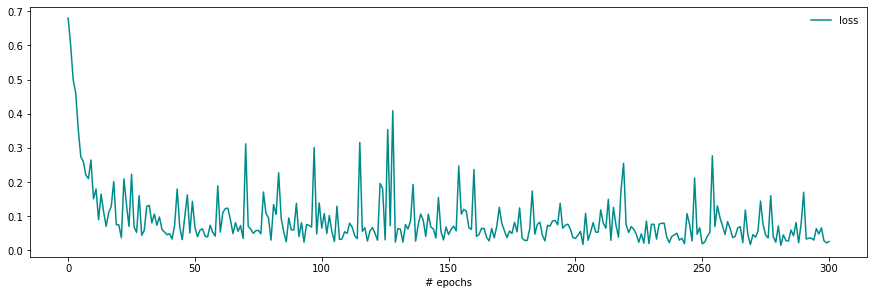

In [11]:
# compute running time
start_time = time.time()

set_seed()  # for reproducibility

# the target will be constant (just one batch)
lossi = np.zeros(n_steps)
miou = []
best_miou = -np.inf
for idx in tqdm(range(n_steps)):
  model.train()
  xb, yb = next(iter(train_loader))
  xb = xb.to(device)
  yb = yb.to(device)

  # Perform a forward pass
  logits = model(xb)["logits"]

  # Clean the gradients  
  optimizer.zero_grad()

  # Compute the loss with class probabilities 
  loss = loss_fn(upscale_logits(logits),
                 yb.squeeze(1).to(torch.long)
  )

  # store the current loss value
  lossi[idx] = loss.item()

  # Backward prop
  loss.backward()

  # Update the parameters
  optimizer.step()

  if idx%eval_steps== 0:
    # Compute mean intersection over union in the valset
    _, val_labels, val_preds, _ = get_pred_label(model, val_loader, device)
    miou.append(torch.mean(compute_iou(val_preds, val_labels)).item())

    if miou[-1] > best_miou:
      print("Saving a checkpoint...")
      best_miou = miou[-1]
      ckpt = {
          'steps': n_steps,
          'cur_steps': idx,
          'state_dict': model.state_dict(),
          'optimizer': optimizer.state_dict(),
      }
      torch.save(ckpt, './ckpt/single-segmentation.pth')
      print("Checkpoint saved!")
    # Print current loss and mIoU
    print(f" -- Loss at epoch {idx}: {lossi[idx]:.4f} | mIoU: {miou[-1]:.4f}")

# compute running time
end_time = time.time()
print(f"--- {end_time - start_time} seconds ---")


plt.figure(figsize=(15, 4.6));
plt.plot(lossi, color="darkcyan", label="loss");
plt.xlabel("# epochs");
plt.legend(frameon=False);

## Load a checkpoint & compute metrics

**Important note:** the `set_seed()` must be equal in this block code
as well as in the training block code. Or you will mixing train and
validation examples in the metrics. This is not the best way to do it, but
you can ensure that the validation is correct looking the first example
image in the val set and comparing with the previous section.

In [12]:
set_seed(42313988)

# Hyperparameters --------------------------------------------------------------
lr = 1e-3           # learning rate
n_steps = 100       # number of steps to update the gradients
eval_steps=10       # evaluate every 10 epochs
BS = 2              # batch-size

# DataLoaders ------------------------------------------------------------------
val_pct = 0.15  # % of validation data
val_size= int(len(dataset) * val_pct)
train_size = len(dataset) - val_size
val_size, train_size

# Split the dataset into training and validation sets
train_set, val_set = random_split(dataset, [train_size, val_size])

val_loader = DataLoader(val_set, batch_size=BS, 
                        shuffle=False, num_workers=0,
                        collate_fn = lambda x: collate_fn(x, target_fn=get_binary_target))

Random seed set as 42313988


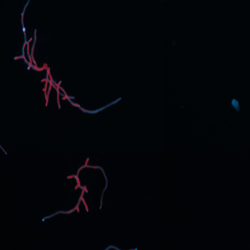

In [13]:
val_set[0]['image'].resize((250, 250))

In [14]:
# Model ----------------------------------------------------------------------- 
set_seed(42313988)  # for reproducibility

stoi = {'normal': 1, 'non-detection': 0}
itos = {1: 'normal', 0: 'non-detection'}

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b0",
    id2label=stoi,
    label2id=itos,
)

# model to device
model=model.to(device)

# Optimizer and loss function --------------------------------------------------
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# Load the checkpoint
ckpt = torch.load('./ckpt/single-segmentation.pth')
model.load_state_dict(ckpt['state_dict'])
optimizer.load_state_dict(ckpt['optimizer'])

Random seed set as 42313988


Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.classifier.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.3.proj.bias', 'decode_head.batc

Recover the mask predictions for the validation set.

In [15]:
_, labels, preds, _ = get_pred_label(model, val_loader, device)
preds.shape, labels.shape

100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


(torch.Size([10, 512, 512]), torch.Size([10, 512, 512]))

In [16]:
val_iou = compute_iou(preds, labels)
print(f"mean IoU on validation set: {torch.mean(val_iou):.4f}")

mean IoU on validation set: 0.5232


In [17]:
print("IoU per each validation example:\n")
val_iou

IoU per each validation example:



tensor([0.6996, 0.5087, 0.7264, 0.0034, 0.5603, 0.4369, 0.5955, 0.6699, 0.3567,
        0.6743])

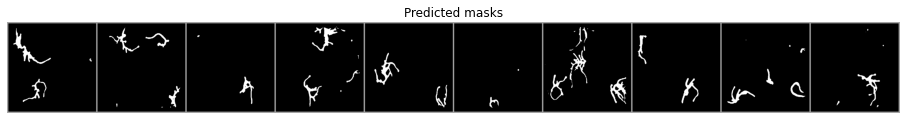

In [18]:
display_batch_masks(preds.unsqueeze(1), caption="Predicted masks")
#plt.savefig("./assets/best-miou-val-prediction-masks.png", dpi=320, bbox_inches='tight')

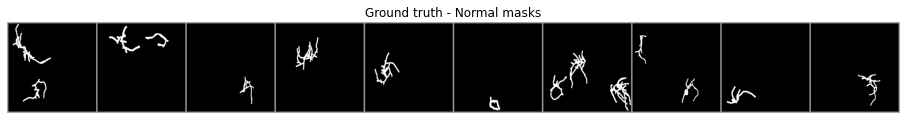

In [19]:
display_batch_masks(labels.unsqueeze(1), caption="Ground truth - Normal masks")
#plt.savefig("./assets/best-miou-val-truth-masks.png", dpi=320, bbox_inches='tight')

Let's zoom in the example with the highest IoU.

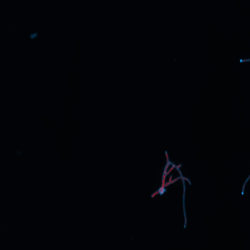

In [20]:
max_iou_idx = torch.argmax(val_iou).item()
val_set[max_iou_idx]['image'].resize((250, 250))

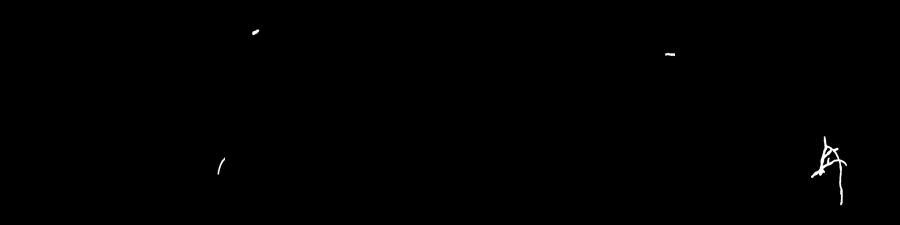

In [21]:
display_masks(val_set[max_iou_idx]['masks'])

The example is pretty simple in visual semantic, let's analyze now the
example with the lowest IoU.

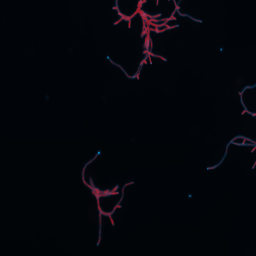

In [22]:
min_iou_idx = torch.argmin(val_iou).item()
val_set[min_iou_idx]['image'].resize((256, 256))

The ground truth mask doesn't match the image, but the prediction is pretty similar. 
We detect an example with a labelling problem in the dataset.

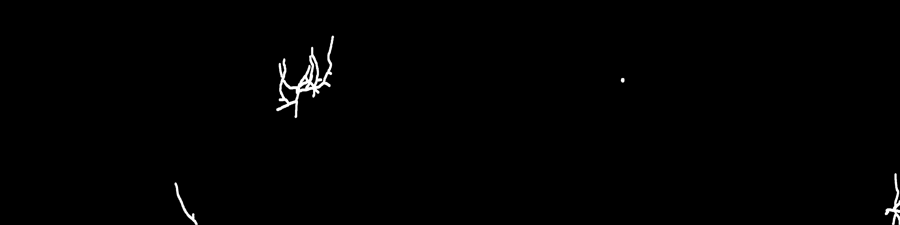

In [23]:
display_masks(val_set[min_iou_idx]['masks'])

### Precision, Recall, and PR-Curves

**TODO**

In [39]:
#threshold = 0.5

#TP = torch.sum(val_iou > threshold).item()
#FP = val_iou.shape[0] - TP

## Training + Logging with W&B

### Validation aux functions

In [ ]:
def validate_model(model, valid_dl, loss_fn, log_images=False, num_classes=2, device="cpu"):
  """Compute performance of the model on the validation dataset and log a wandb.Table"""
  device=device
  model.eval()
  val_loss = 0.
  iou = 0.
  with torch.inference_mode():
    correct = 0

    iou_by_example = torch.zeros(len(valid_dl.dataset)) # tensor with length equals to the number of validation examples
    for i, (images, masks) in enumerate(valid_dl):
      images, masks = images.to(device), masks.to(device)
      masks=flatten_logits(torch.where(masks > 0.0, 1.0, 0.0))

      # Forward pass ➡
      logits = model(images)["logits"]
      probs = torch.softmax(upscale_logits(logits), dim=1)
      _, predicted = torch.max(probs.data, dim=1)
      probs = probs[:, 1, :, :]
      preds = flatten_logits(probs)
      val_loss+= loss_fn(preds, masks).item()*masks.size(0)

      # Compute pixel accuracy and accumulate
      correct += (flatten_logits(predicted) == masks).sum().item()

      # Compute IoU and accumulate
      mask2d=masks.view(masks.shape[0], predicted.shape[1], -1)
      intersection = torch.logical_and(mask2d, predicted)
      union = torch.logical_or(mask2d, predicted)
      iou += (torch.div(torch.sum(intersection, dim=(1,2)) + 1e-6, (torch.sum(union, dim=(1,2)) + 1e-6)).sum()/predicted.shape[0]).item()

      # tensor with IoU for every example (batch_size x 1)
      iou_by_example = intersection.sum(dim=(1,2), keepdim=False) / (union.sum(dim=(1,2), keepdim=False) + 1e-6)

      
      # Log validation predictions and images to the dashboard
      if log_images:
        if i == 0:
          # 🐝 Create a wandb Table to log images, labels and predictions to
          table = wandb.Table(columns=["image", "mask", "pred_mask", "probs", "iou"])
          for img, mask, pred, prob, iou_metric in zip(images.to("cpu"), masks.to("cpu"), predicted.to("cpu"), probs.to("cpu"), iou_by_example.to("cpu")):
            plt.imshow(prob.detach().cpu());
            plt.axis("off");
            plt.tight_layout();
            table.add_data(wandb.Image(img.permute(1,2,0).numpy()), 
                           wandb.Image(mask.view(img.shape[1:]).unsqueeze(2).numpy()),
                           wandb.Image(np.uint8(pred.unsqueeze(2).numpy())*255),
                           wandb.Image(plt),
                           iou_metric
                           )
    if log_images:
      wandb.log({"val_table/predictions_table":table}, commit=False)

  return (
        val_loss / len(valid_dl.dataset), 
        correct / (len(valid_dl.dataset)*512**2),
        iou / (i+1)
  )

In [8]:
set_seed(42313988)
# Hyperparameters --------------------------------------------------------------
lr = 1e-3           # learning rate
n_steps = 301       # number of steps to update the gradients
eval_steps=25       # evaluate every 10 epochs
BS = 2              # batch-size

# DataLoaders ------------------------------------------------------------------
val_pct = 0.15  # % of validation data
val_size= int(len(dataset) * val_pct)
train_size = len(dataset) - val_size
val_size, train_size

# Split the dataset into training and validation sets
train_set, val_set = random_split(dataset, [train_size, val_size])

# Create data loaders for the training and validation sets
train_loader = DataLoader(train_set, batch_size=BS, 
                          shuffle=True, num_workers=0,
                          collate_fn = lambda x: collate_fn(x, target_fn=get_binary_target))

val_loader = DataLoader(val_set, batch_size=BS, 
                        shuffle=False, num_workers=0,
                        collate_fn = lambda x: collate_fn(x, target_fn=get_binary_target))

Random seed set as 42313988


In [ ]:
# Model ----------------------------------------------------------------------- 
set_seed(42313988)  # for reproducibility

stoi = {'normal': 1, 'non-detection': 0}
itos = {1: 'normal', 0: 'non-detection'}

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b0",
    id2label=stoi,
    label2id=itos,
)

# model to device
model=model.to(device)

# Optimizer and loss function --------------------------------------------------
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [ ]:
# compute running time
start_time = time.time()

set_seed()  # for reproducibility

# the target will be constant (just one batch)
lossi = np.zeros(n_steps)
miou = []
best_miou = -np.inf
for idx in tqdm(range(n_steps)):
  model.train()
  xb, yb = next(iter(train_loader))
  xb = xb.to(device)
  yb = yb.to(device)

  # Perform a forward pass
  logits = model(xb)["logits"]

  # Clean the gradients  
  optimizer.zero_grad()

  # Compute the loss with class probabilities 
  loss = loss_fn(upscale_logits(logits),
                 yb.squeeze(1).to(torch.long)
  )

  # store the current loss value
  lossi[idx] = loss.item()

  # Backward prop
  loss.backward()

  # Update the parameters
  optimizer.step()

  if idx%eval_steps== 0:
    # Compute mean intersection over union in the valset
    _, val_labels, val_preds, _ = get_pred_label(model, val_loader, device)
    miou.append(torch.mean(compute_iou(val_preds, val_labels)).item())

    if miou[-1] > best_miou:
      print("Saving a checkpoint...")
      best_miou = miou[-1]
      ckpt = {
          'steps': n_steps,
          'cur_steps': idx,
          'state_dict': model.state_dict(),
          'optimizer': optimizer.state_dict(),
      }
      torch.save(ckpt, './ckpt/single-segmentation.pth')
      print("Checkpoint saved!")
    # Print current loss and mIoU
    print(f" -- Loss at epoch {idx}: {lossi[idx]:.4f} | mIoU: {miou[-1]:.4f}")

# compute running time
end_time = time.time()
print(f"--- {end_time - start_time} seconds ---")


plt.figure(figsize=(15, 4.6));
plt.plot(lossi, color="darkcyan", label="loss");
plt.xlabel("# epochs");
plt.legend(frameon=False);